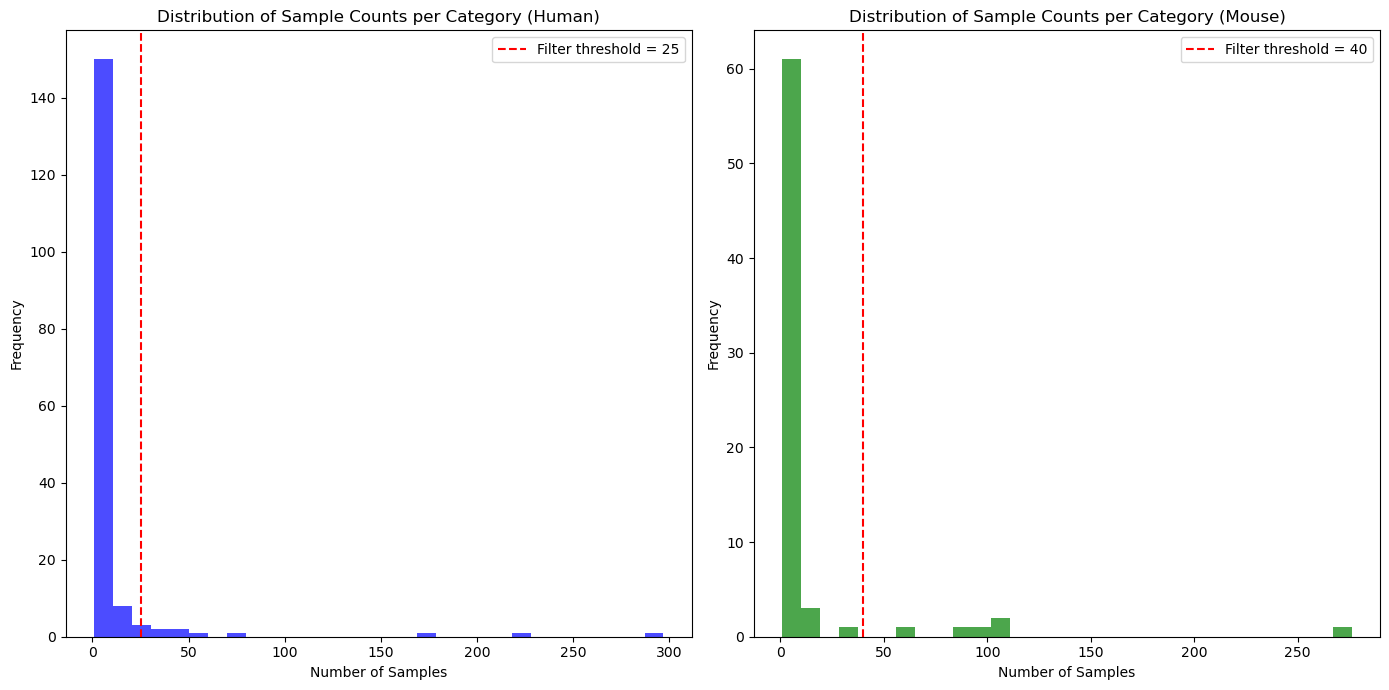

Human Data Sample Counts Statistics:
count    170.000000
mean       9.041176
std       31.998586
min        1.000000
25%        1.000000
50%        2.000000
75%        4.000000
max      297.000000
Name: epitope, dtype: float64

Mouse Data Sample Counts Statistics:
count     71.000000
mean      12.957746
std       39.643208
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max      276.000000
Name: epitope, dtype: float64

Human Data Percentiles:
50.0% of the categories have at least 2.0 samples.
75.0% of the categories have at least 4.0 samples.
90.0% of the categories have at least 13.199999999999989 samples.
95.0% of the categories have at least 30.099999999999966 samples.

Mouse Data Percentiles:
50.0% of the categories have at least 1.0 samples.
75.0% of the categories have at least 4.0 samples.
90.0% of the categories have at least 16.0 samples.
95.0% of the categories have at least 92.0 samples.
Best parameters for Human: {'n_neighbors': 7, 'p': 1, '

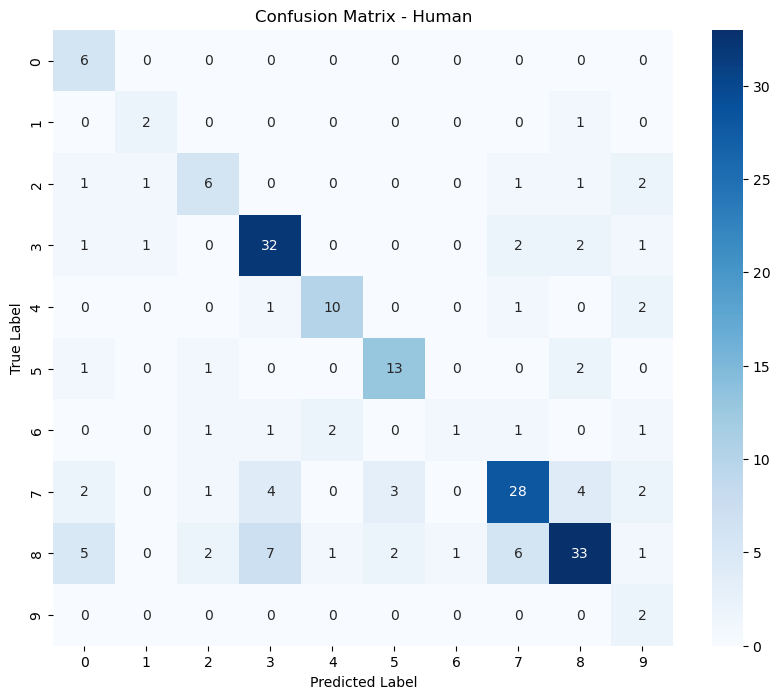

Best parameters for Mouse: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy-Mouse: 0.80
Precision-Mouse: 0.81
Recall-Mouse: 0.80
F1 Score-Mouse: 0.79
Confusion Matrix for Mouse:
[[18  0  1  0  3  0]
 [ 2 14  0  0  0  0]
 [ 1  1 13  0  3  0]
 [ 0  0  0 10  0  0]
 [ 2  1  5  4 54  0]
 [ 0  0  1  1  5  8]]


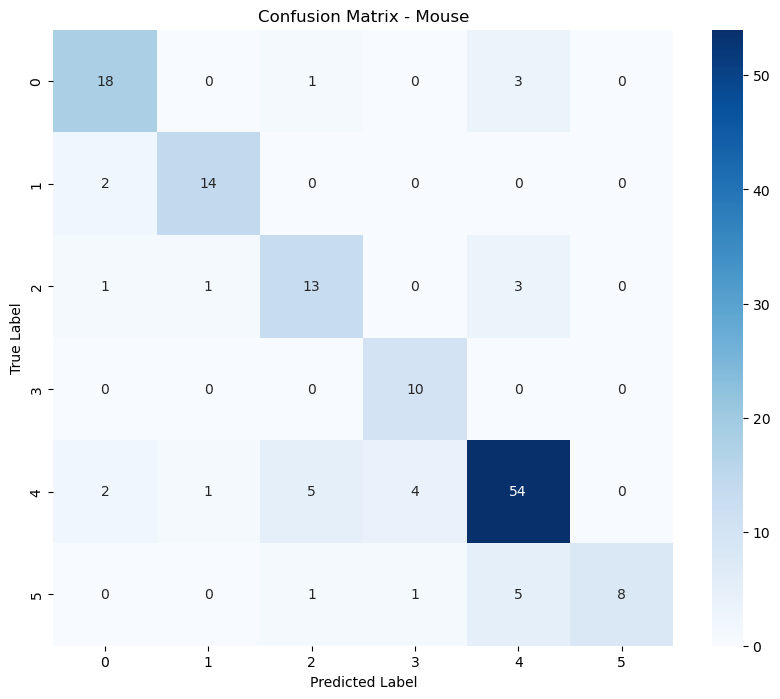

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Read data
tr_mouse_alpha_beta_color = pd.read_csv("tr_mouse_alpha_beta_color.csv")
tr_human_alpha_beta_color = pd.read_csv("tr_human_alpha_beta_color.csv")

tr_mouse_alpha_beta = pd.read_csv("tr_mouse_alpha_beta.csv").values
tr_human_alpha_beta = pd.read_csv("tr_human_alpha_beta.csv").values

# Visualize sample counts distribution for human and mouse
value_counts_human = tr_human_alpha_beta_color['epitope'].value_counts()
value_counts_mouse = tr_mouse_alpha_beta_color['epitope'].value_counts()

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(value_counts_human, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Sample Counts per Category (Human)')
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.axvline(x=25, color='red', linestyle='--', label='Filter threshold = 25')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(value_counts_mouse, bins=30, color='green', alpha=0.7)
plt.title('Distribution of Sample Counts per Category (Mouse)')
plt.xlabel('Number of Samples')
plt.ylabel('Frequency')
plt.axvline(x=40, color='red', linestyle='--', label='Filter threshold = 40')
plt.legend()

plt.tight_layout()
plt.show()

# Print descriptive statistics for human and mouse data
print("Human Data Sample Counts Statistics:")
print(value_counts_human.describe())

print("\nMouse Data Sample Counts Statistics:")
print(value_counts_mouse.describe())

# Calculate and print different percentiles for human and mouse
percentiles = [0.50, 0.75, 0.90, 0.95]
print("\nHuman Data Percentiles:")
for p in percentiles:
    percentile_value = value_counts_human.quantile(p)
    print(f"{p*100}% of the categories have at least {percentile_value} samples.")

print("\nMouse Data Percentiles:")
for p in percentiles:
    percentile_value = value_counts_mouse.quantile(p)
    print(f"{p*100}% of the categories have at least {percentile_value} samples.")

# Filter categories with less than a certain number of samples
valid_categories_mouse = value_counts_mouse[value_counts_mouse >= 40].index
filtered_mouse_data = tr_mouse_alpha_beta_color[tr_mouse_alpha_beta_color['epitope'].isin(valid_categories_mouse)]

valid_categories_human = value_counts_human[value_counts_human >= 25].index
filtered_human_data = tr_human_alpha_beta_color[tr_human_alpha_beta_color['epitope'].isin(valid_categories_human)]

# Convert categories to codes
labels_human = pd.Categorical(filtered_human_data['epitope']).codes
labels_mouse = pd.Categorical(filtered_mouse_data['epitope']).codes

# Filter and update similarity matrix indices
X_human_filtered = tr_human_alpha_beta[np.ix_(filtered_human_data.index, filtered_human_data.index)]
X_mouse_filtered = tr_mouse_alpha_beta[np.ix_(filtered_mouse_data.index, filtered_mouse_data.index)]

scaler_human = StandardScaler()
scaler_mouse = StandardScaler()
tr_human_alpha_beta_scaled = scaler_human.fit_transform(tr_human_alpha_beta)

# Fit the scaler to the mouse data and transform it
tr_mouse_alpha_beta_scaled = scaler_mouse.fit_transform(tr_mouse_alpha_beta)




# Function to optimize KNN parameters
def optimize_knn_parameters(X, y):
    knn = KNeighborsClassifier(metric='precomputed', algorithm='brute')
    param_grid = {
        'n_neighbors': [ 3, 5, 7, 9,11 ],
        'weights': ['uniform', 'distance'],
        'p': [1, 2, 3]
    }
    stratified_k_fold = StratifiedKFold(n_splits=10)  # Cross-validation
    grid_search = GridSearchCV(knn, param_grid, cv=stratified_k_fold, scoring='accuracy', n_jobs=-1)  # Parallel search
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_

# Function to perform analysis
def perform_analysis(X, labels, title):
    indices = np.arange(len(labels))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=1)
    X_train = X[np.ix_(train_indices, train_indices)]
    X_test = X[np.ix_(test_indices, train_indices)]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    best_knn, best_params = optimize_knn_parameters(X_train, y_train)
    print(f'Best parameters for {title}: {best_params}')
    
    y_pred = best_knn.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print performance metrics
    print(f'Accuracy-{title}: {accuracy:.2f}')
    print(f'Precision-{title}: {precision:.2f}')
    print(f'Recall-{title}: {recall:.2f}')
    print(f'F1 Score-{title}: {f1:.2f}')

    # Generate and print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f'Confusion Matrix for {title}:')
    print(cm)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Return the metrics
    return accuracy, precision, recall, f1

# ...

# Call perform_analysis for human and mouse data
results_human = perform_analysis(X_human_filtered, labels_human, "Human")
results_mouse = perform_analysis(X_mouse_filtered, labels_mouse, "Mouse")







